## scRNAseq: Epithelial-Mesenchymal Transition in Cancer
Dataset 3 from: [Cook and Vanderhyden 2020](https://www.nature.com/articles/s41467-020-16066-2)

In [1]:
import os
currDir = os.getcwd()

In [2]:
# Cook conditions
all_runs = ["A549-EGF", "A549-TNF",
            "DU145-EGF", "DU145-TNF",
            "MCF7-EGF", "MCF7-TGFB1", "MCF7-TNF"]

run_name = all_runs[0]
dataset_name = "3-Cook"

In [3]:
file_name = run_name
run_name

'A549-EGF'

## Run Settings

Import Cook functions

In [4]:
os.chdir(currDir)
%run Cook_functions.ipynb
setDirectories(dataset_name, run_name)

In [5]:
sc.settings.set_figure_params(dpi=150, figsize=[5,5])
plt.rcParams['figure.figsize']=(5,5)

Import settings for current run

In [6]:
run_settings = importSettings(run_name)

total_counts_cutoff = run_settings["total_counts_cutoff"]
mito_cutoff = run_settings["mito_cutoff"]
ribo_cutoff = run_settings["ribo_cutoff"]
leiden_resolution = run_settings["leiden_resolution"]
EMT_clusters_in_order = run_settings["EMT_clusters_in_order"].split(",")
EMT_clusters_in_order = [int(i) for i in EMT_clusters_in_order]
pseudotime_DC = run_settings["pseudotime_DC"]
pseudotime_DC_rootNodes = run_settings["pseudotime_DC_rootNodes"]

# Add markers for visualization, if wanted
run_E_markers = run_settings["run_E_markers"].split(", ") if str(run_settings["run_E_markers"]) != "nan" else ""
run_M_markers = run_settings["run_M_markers"].split(", ") if str(run_settings["run_M_markers"]) != "nan" else ""

## Part 1: IMPORT DATA, FILTERING, AND NORMALIZATION

In [7]:
adata = importData(dataset_name, run_name)
adata = filterData(adata)
adata = find_Mito(adata)
adata = filter_MitoRibo(adata, total_counts_cutoff, mito_cutoff, ribo_cutoff, run_name, dataset_name)
saveFilteredData(adata, run_name)
adataHiVar = normalize_and_hiVar_Data(adata, run_name)

In [8]:
check_cell_cycle(run_name)

## Part 2: EMTSCORE AND CLUSTERING

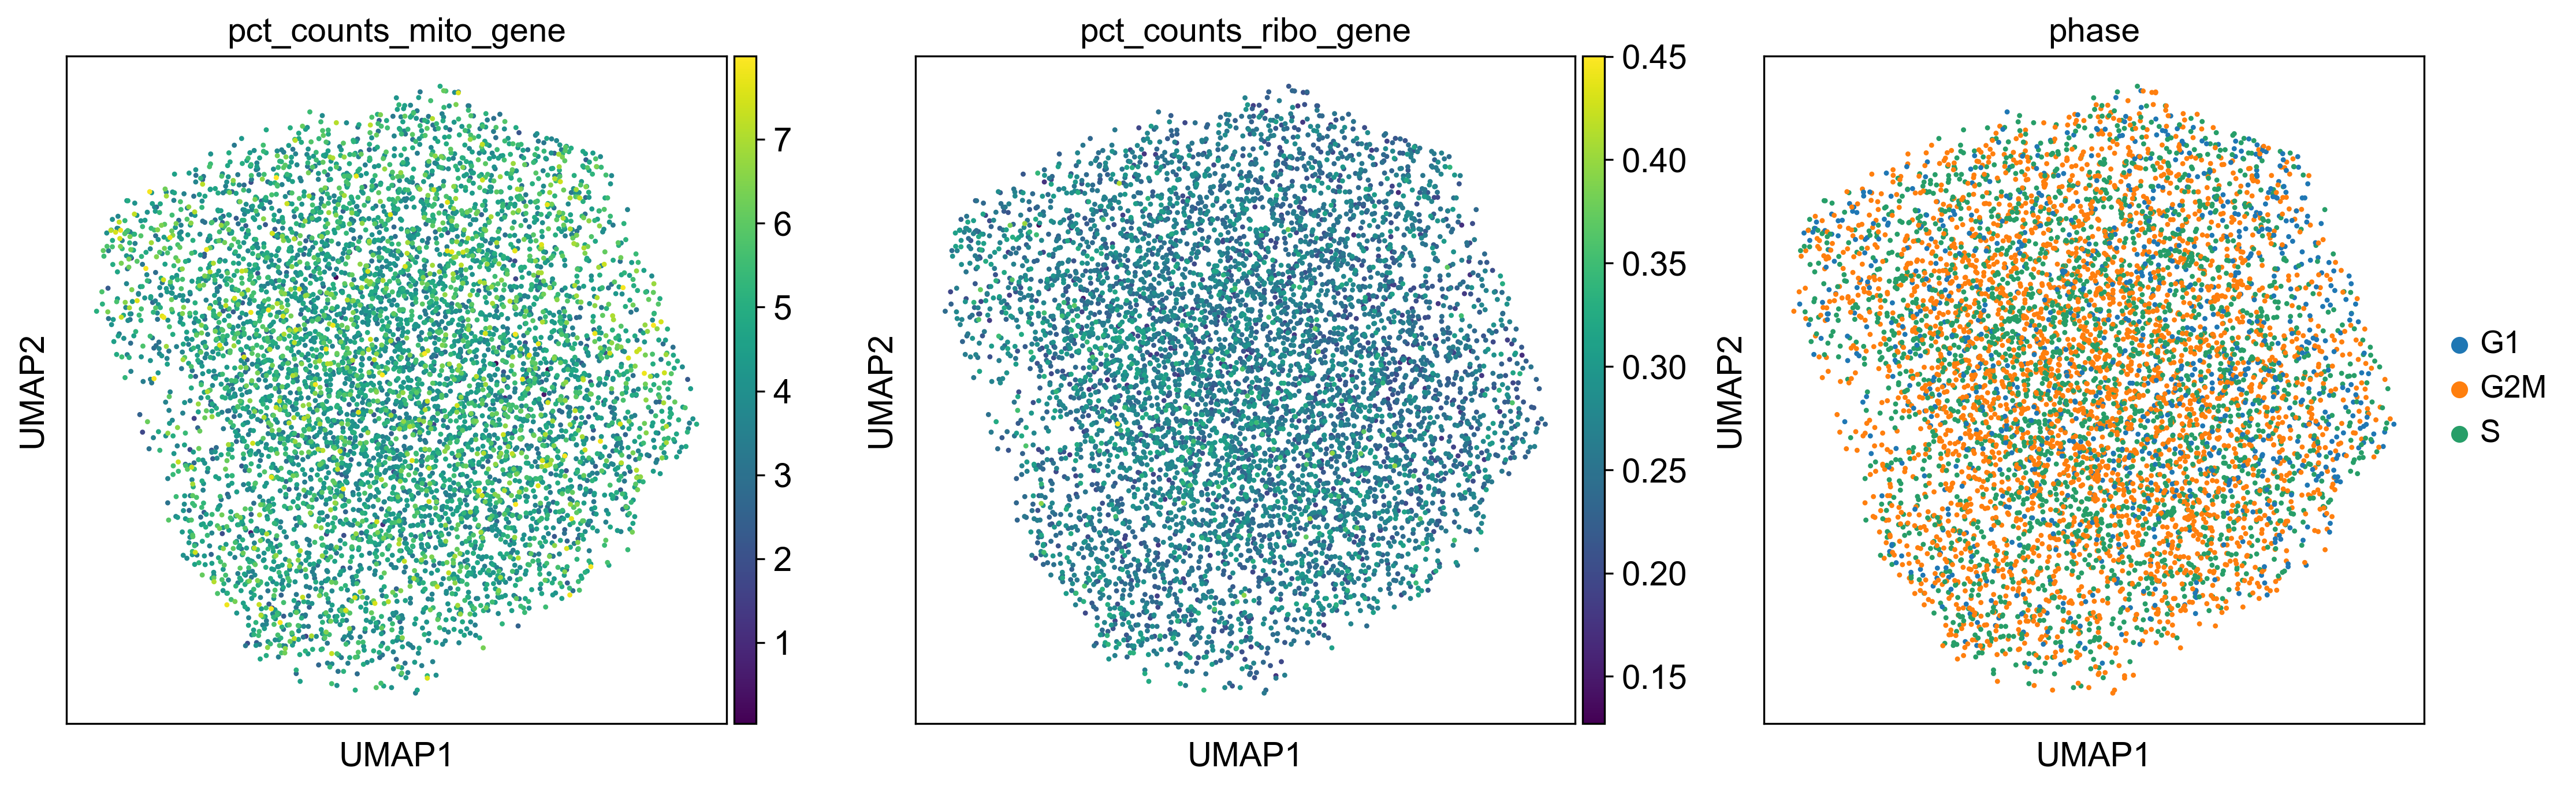

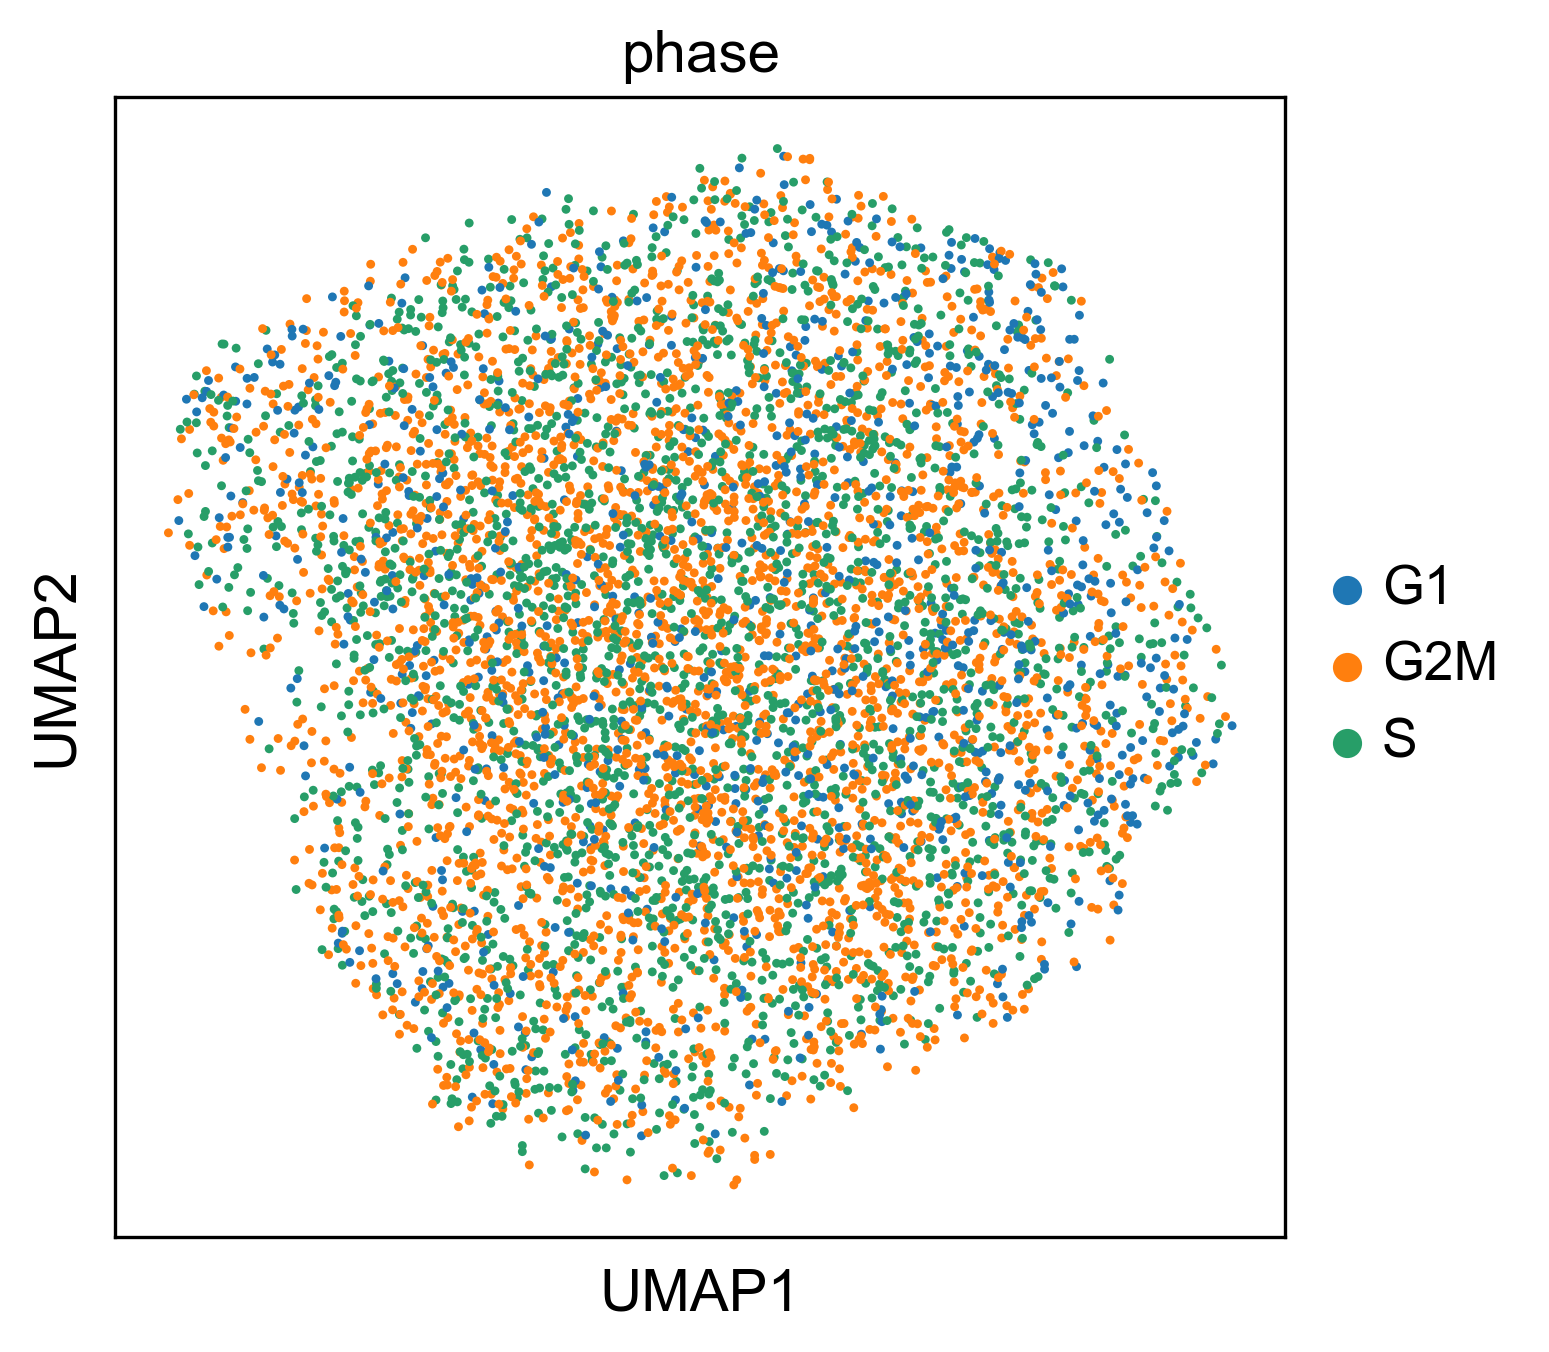

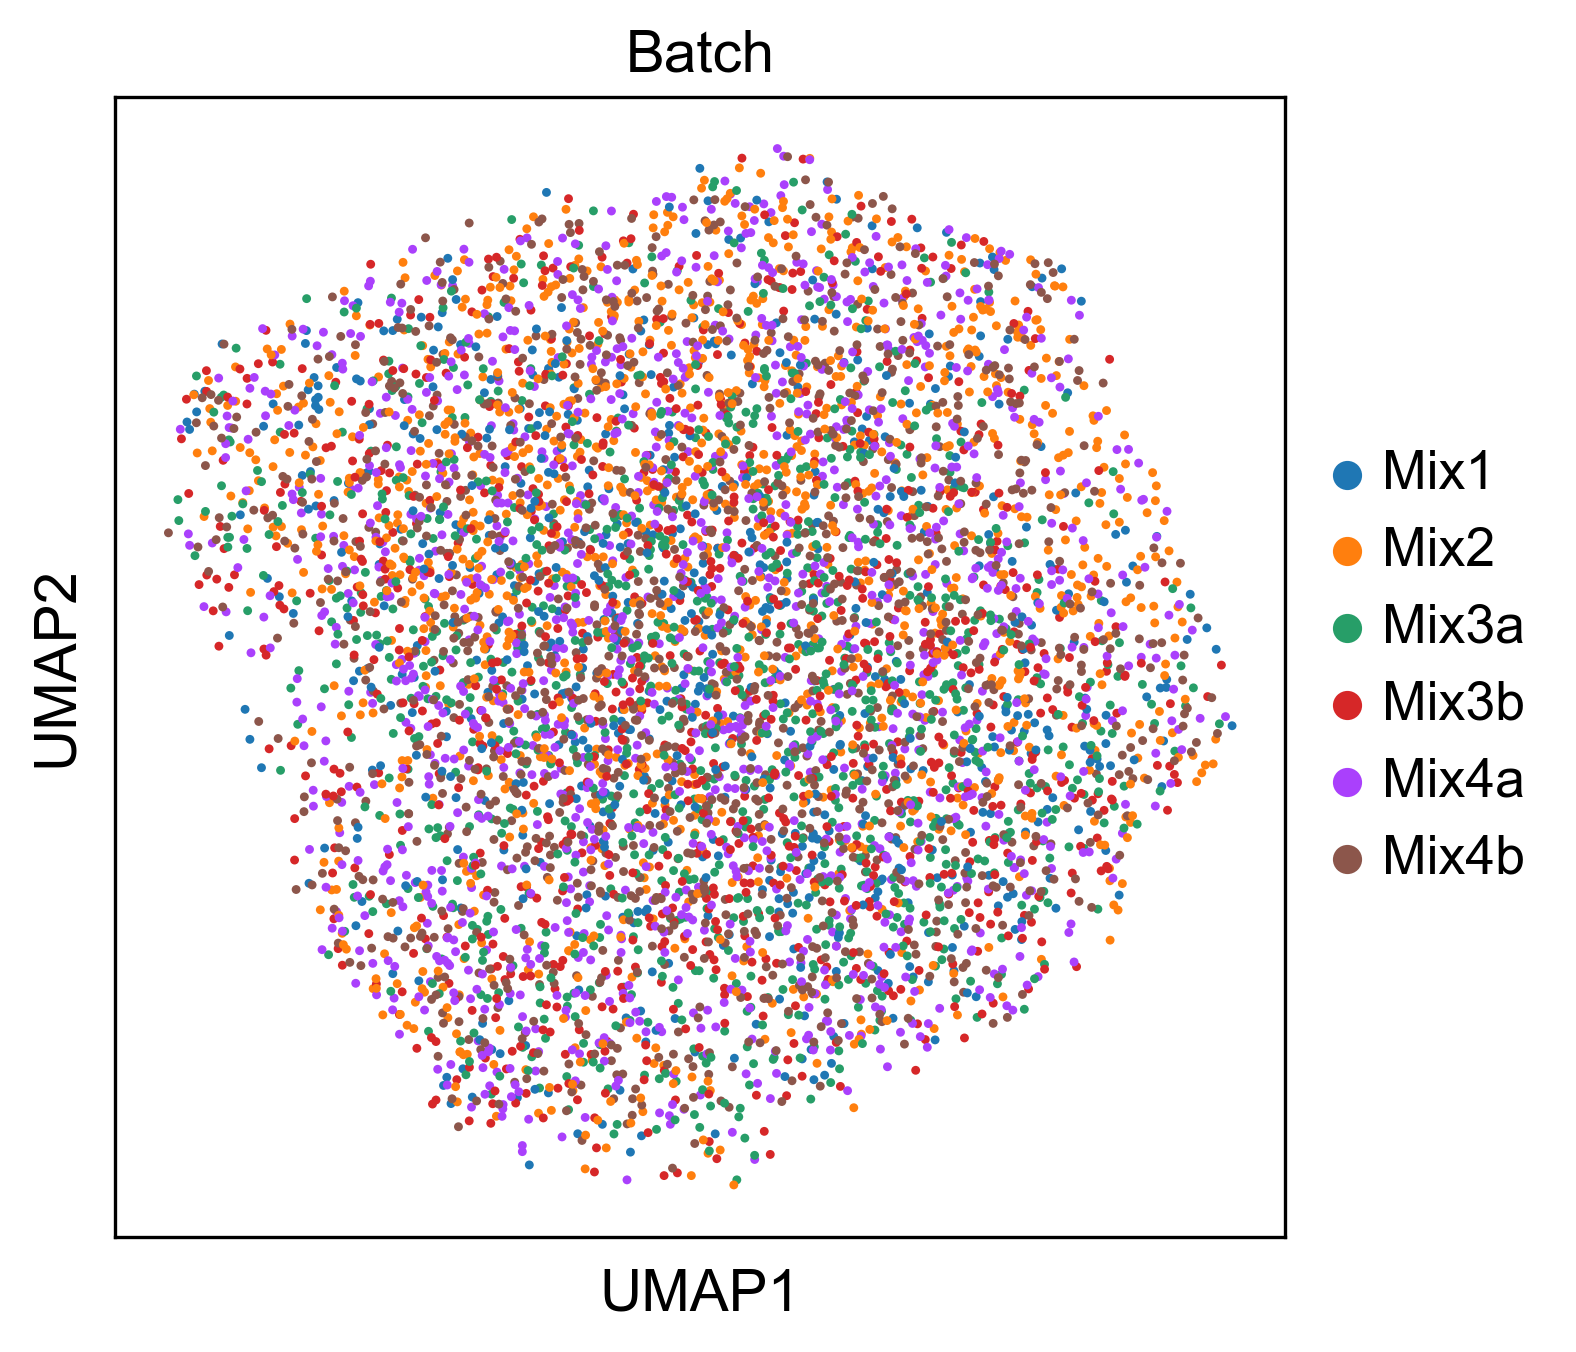

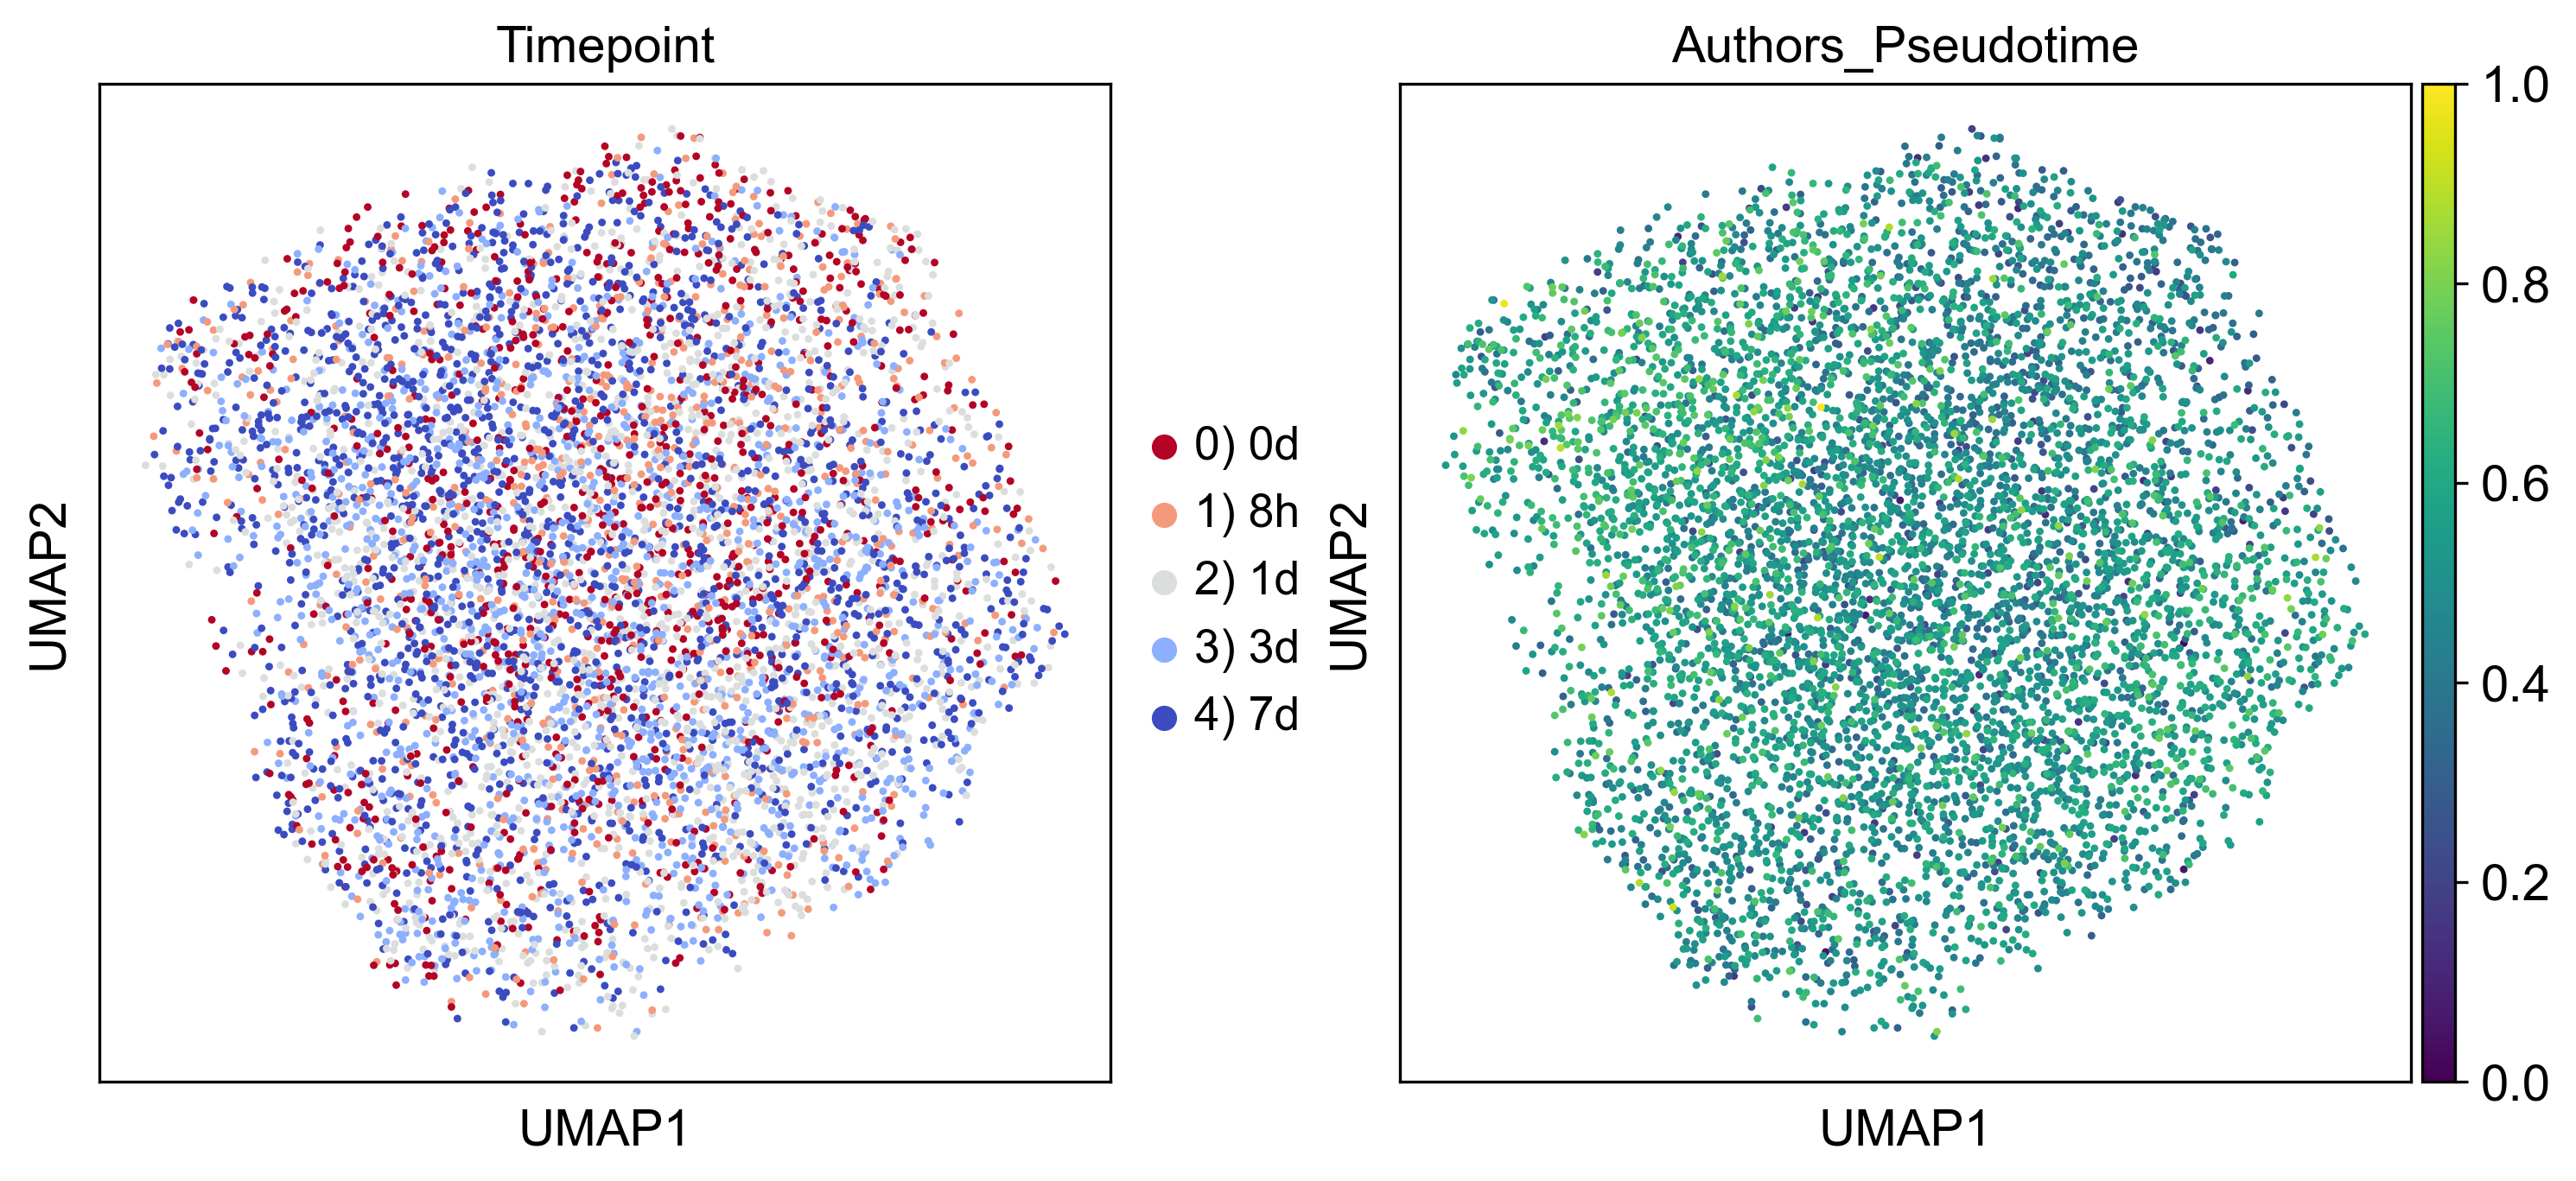

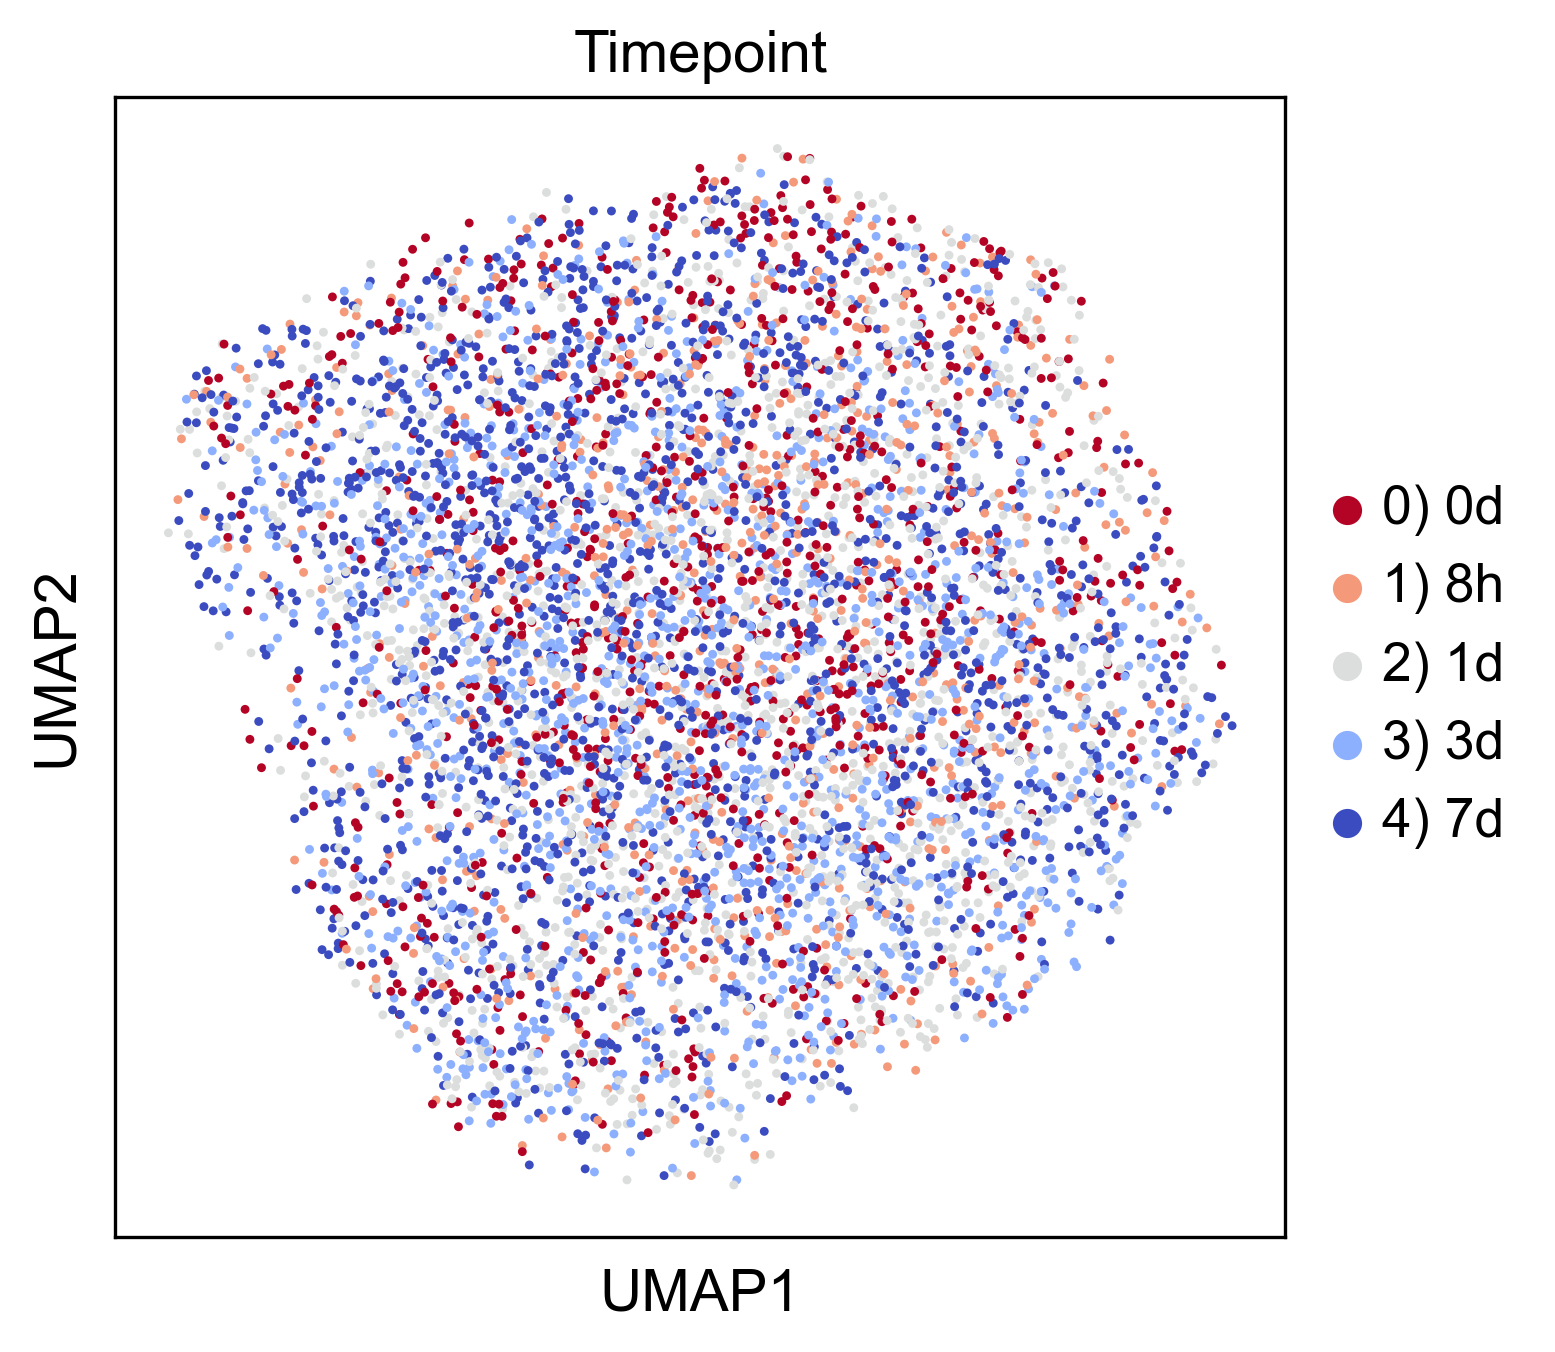

In [9]:
adataHiVar, df_normalized = importProcessedData(dataset_name, run_name)
adataHiVar = Cook_unique_filter(adataHiVar, run_name)
adataHiVar = PCA(adataHiVar)
adataHiVar = UMAP(adataHiVar)

In [ ]:
adataHiVar = leiden(adataHiVar, leiden_resolution, EMT_clusters_in_order, run_name)
adataHiVar = leiden_marker_genes(adataHiVar, dataset_name, run_name)
leiden_marker_genes_highlight(run_name, df_normalized)

In [14]:
# Export DE genes and log2FC for each cluster
for currCluster in adataHiVar.obs["leiden_label"].unique():
    cluster_DE_genes_export(adataHiVar, dataset_name, run_name, EMT_clusters_in_order, currCluster)

In [15]:
# EMTscore from UCell
adataHiVar = UCell_export_import(adataHiVar, run_name)
sc.pl.violin(adataHiVar, keys=["UCell_EMTscore"])

In [20]:
saveClusteredData(adataHiVar, run_name)

## Part 3: PSEUDOTIME

In [21]:
adataHiVar = importClusteredData(dataset_name, run_name)
adataHiVar = diffmap(adataHiVar)
root_nodes = pseudotime_rootNodes(adataHiVar, pseudotime_DC, pseudotime_DC_rootNodes, run_name)
adataHiVar, df_pseudotime = pseudotime_mean(adataHiVar, root_nodes)
savePseudotimeData(adataHiVar, run_name)

In [23]:
pseudotime_per_cluster(adataHiVar, EMT_clusters_in_order, run_name, df_pseudotime)